# 実践コンピュータビジョン
# 5章 多視点幾何
## 5.3 多視点による復元

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
import homography
import sfm
import sift

In [3]:
# キャリブレーション
K = np.array([[2394, 0, 932], [0, 2398, 628], [0, 0, 1]])

In [4]:
# 画像を読み込み特徴点を計算する
im1 = np.array(Image.open('data/alcatraz1.jpg'))
sift.process_image('data/alcatraz1.jpg', 'data/alcatraz1.sift')
l1,d1 = sift.read_features_from_file('data/alcatraz1.sift')

im2 = np.array(Image.open('data/alcatraz2.jpg'))
sift.process_image('data/alcatraz2.jpg', 'data/alcatraz2.sift')
l2,d2 = sift.read_features_from_file('data/alcatraz2.sift')

processed tmp.pgm to data/alcatraz1.sift
processed tmp.pgm to data/alcatraz2.sift


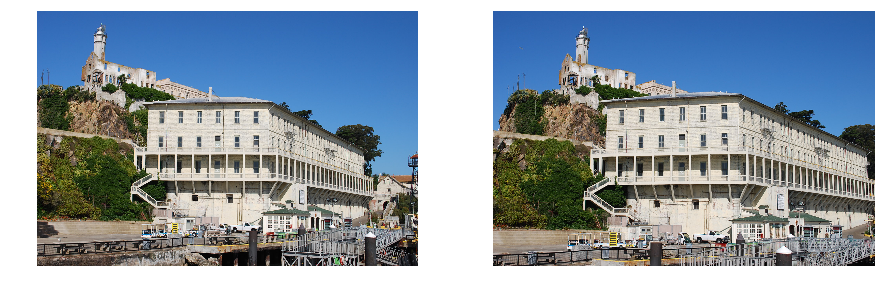

In [5]:
# 多視点復元をする対象の２枚の写真（アルカトラズ島の風景）
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(im1)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(im2)
plt.axis('off')
plt.show()

In [6]:
# 特徴点を対応づける
matches = sift.match_twosided(d1, d2) # 処理に時間がかかる
ndx = matches.nonzero()[0]

In [7]:
# 同次座標にしinv(K)を使って正規化する
x1 = homography.make_homog(l1[ndx,:2].T)
ndx2 = [int(matches[i]) for i in ndx]
x2 = homography.make_homog(l2[ndx2,:2].T)

In [8]:
# 正規化した座標
x1n = np.dot(np.linalg.inv(K),x1)
x2n = np.dot(np.linalg.inv(K),x2)

In [9]:
# RANSACでEを推定
model = sfm.RansacModel()
E,inliers = sfm.F_from_ransac(x1n,x2n,model) # 処理に時間がかかる

In [11]:
# カメラ行列を計算する（P2は4つの解のリスト）
P1 = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
P2 = sfm.compute_P_from_essential(E)

In [12]:
# 2つのカメラの前に点のある解を選ぶ
ind = 0
maxres = 0
for i in range(4):
    # triangulate inliers and compute depth for each camera
    # インライアを三角測量し各カメラからの奥行きを計算する
    X = sfm.triangulate(x1n[:,inliers],x2n[:,inliers],P1,P2[i])
    d1 = np.dot(P1,X)[2]
    d2 = np.dot(P2[i],X)[2]
    if np.sum(d1>0)+np.sum(d2>0) > maxres:
        maxres = np.sum(d1>0)+np.sum(d2>0)
        ind = i
        infront = (d1>0) & (d2>0)

In [13]:
# インライアを三角測量し両方のカメラの正面に含まれていない点を削除します。
X = sfm.triangulate(x1n[:,inliers],x2n[:,inliers],P1,P2[ind])
X = X[:,infront]

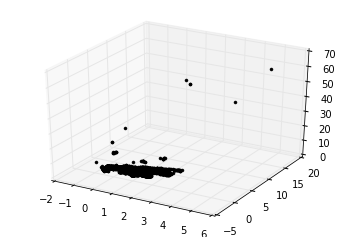

In [15]:
# 3D描画
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(-X[0],X[1],X[2],'k.') # 第1軸の符号を反転してプロット
# plt.axis('off')

上記では２枚の写真から復元した3Dモデルをプロットした。<br>
ここでは第1軸の符号を反転して、プロットしている。<br>

### 視点ごとの復元結果の描画
3Dモデルに復元した点を２枚の写真のそれぞれに射影して、復元結果を描画する。

In [16]:
# Xの射影を描画する
import camera

In [17]:
# 3Dの点群を射影変換する
cam1 = camera.Camera(P1)
cam2 = camera.Camera(P2[ind])
x1p = cam1.project(X)
x2p = cam2.project(X)

3Dの点を射影変換したら、キャリブレーション行列を掛けて、最初に施した正規化を元に戻す必要がある。

In [18]:
# Kの正規化を戻す
x1p = np.dot(K,x1p)
x2p = np.dot(K,x2p)

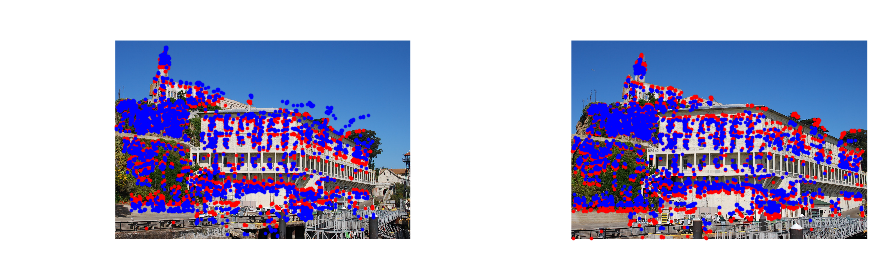

In [26]:
# １枚目の写真（左）
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(im1)
plt.gray()
plt.plot(x1[0],x1[1],'r.') # SIFT特徴量から抽出した点群
plt.plot(x1p[0],x1p[1],'b.') # 3Dモデルから復元した点群
plt.axis('off')

# ２枚目の写真（右）
plt.subplot(1,2,2)
plt.imshow(im2)
plt.gray()
plt.plot(x2[0],x2[1],'r.') # SIFT特徴量から抽出した点群
plt.plot(x2p[0],x2p[1],'b.') # 3Dモデルから復元した点群
plt.axis('off')
plt.show()

### 結果
再射影された点は元の特徴点の位置と必ずしも正確には一致しないが、ある程度近い結果になった。